In [1]:
import pandas as pd
import numpy as np
from json import loads
import pandas as pd
import psycopg2 
import csv
#from urllib import parse, request
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#import holoviews as hv
#hv.extension('matplotlib', width="100")
#%opts Curve [width=1200 height=500 tools=['hover'] ] {+framewise} VLine (color="black")
#%opts Bars  [width=800 height=400 tools=['hover'] group_index=1 legend_position='top_left' xrotation=90]

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [111]:
list_cat_map = []
with open('catmapping.txt') as f:
    list_cat_map = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
list_cat_map = [x.strip() for x in list_cat_map]

In [112]:
cat_map={}
for i in list_cat_map:
    cat_map[int(i.split('\t')[0])]=i.split('\t')[1]

In [114]:
df_cat_map=pd.DataFrame.from_dict(cat_map,orient='index')
df_cat_map=df_cat_map.reset_index().rename(columns={'index':'nodeid',0:'catnum'})

In [115]:
df_cat_map

,nodeid,catnum
0,1,247
1,173508,247
2,266162,247
3,720870,247
4,3564986011,247
5,882340,247
6,1007,919
7,1002,247
8,4539344011,247
9,266160,247


In [2]:
#Extract the features from DB
conn = psycopg2.connect("dbname='SQLBook' user='postgres' host='localhost' password='postgres' password='postgres'")
cur = conn.cursor()

In [3]:
cur.execute("""select o.customerid,p.asin,p.nodeid from customers c,
orders o, orderlines ol,products p
where c.customerid = o.customerid
and o.orderid =ol.orderid
and ol.productid =p.productid
and c.customerid in (select o1.customerid from orders o1,orderlines ol1 
where o1.orderid =ol1.orderid
group by o1.customerid
having count(distinct(ol1.productid))=1)
group by o.customerid,p.asin,p.nodeid""")
rows = cur.fetchall()

df = pd.DataFrame(rows,columns=['customerid','asin','nodeid'])

In [5]:
df

,customerid,asin,nodeid
0,1,0004990218,2963
1,2,0003708861,8951153011
2,3,0006810195,13682
3,4,0003801055,8951155011
4,5,000611718X,8944264011
5,6,0000202010,266160
6,9,000611718X,8944264011
7,11,0007103867,171114
8,12,000611718X,8944264011
9,13,0005152062,3214


In [4]:
matrix_co = np.load('rating_indexed.npy')

In [5]:
def get_idx_from_asin(asin_list):
    list_idx = []
    for asin in asin_list:
        #print (asin)
        try:
            list_idx.append(list_asin_names.index(asin))
        except ValueError:
            pass
    return list_idx

In [6]:
list_asin_names=list(np.load('asin.npy'))
list_asin_names=[i.decode() for i in list_asin_names]

In [7]:
df['asin_index']=-1

In [8]:
def get_asin_index(x):
    l=[]
    l.append(x['asin'])
    x['asin_index']=get_idx_from_asin(l)[0]
    return x

In [9]:
df=df.apply(lambda x: get_asin_index(x),axis=1)

In [10]:
arg_num_rec=10

In [11]:
indices = np.nonzero(matrix_co)[0]
toprec = indices[np.argsort(matrix_co[indices])][-1 * arg_num_rec:][::-1]

In [12]:
df_indexed=df.groupby('asin_index').count().sort_values(by='asin',ascending=False)

In [13]:
for i in toprec:
    print (df_indexed[df_indexed.index==i])

            customerid  asin  nodeid
asin_index                          
2025              1203  1203    1203
            customerid  asin  nodeid
asin_index                          
2864               335   335     335
            customerid  asin  nodeid
asin_index                          
1874                62    62      62
            customerid  asin  nodeid
asin_index                          
2845                 6     6       6
            customerid  asin  nodeid
asin_index                          
3220                25    25      25
            customerid  asin  nodeid
asin_index                          
2782                 2     2       2
            customerid  asin  nodeid
asin_index                          
747                123   123     123
            customerid  asin  nodeid
asin_index                          
1019              3833  3833    3833
            customerid  asin  nodeid
asin_index                          
2655               198   198     198
 

In [17]:
overall_df=pd.merge(df,pd.DataFrame(matrix_co,columns=['rating']).reset_index(),left_on='asin_index',right_on='index')

In [121]:
new_over_df=pd.merge(overall_df.apply(pd.to_numeric, errors='ignore'),df_cat_map,on='nodeid',how='left')

In [122]:
new_over_df

,customerid,asin,nodeid,asin_index,index,rating,catnum
0,1,0004990218,2963,3532,3532,12.501634,667
1,161,0004990218,2963,3532,3532,12.501634,667
2,188,0004990218,2963,3532,3532,12.501634,667
3,287,0004990218,2963,3532,3532,12.501634,667
4,551,0004990218,2963,3532,3532,12.501634,667
5,627,0004990218,2963,3532,3532,12.501634,667
6,628,0004990218,2963,3532,3532,12.501634,667
7,753,0004990218,2963,3532,3532,12.501634,667
8,867,0004990218,2963,3532,3532,12.501634,667
9,871,0004990218,2963,3532,3532,12.501634,667


In [123]:
#create random list of 10 categories
cat=[]
#create_seed(2)
cat=np.random.permutation(new_over_df['catnum'].unique())[:10]

In [129]:
new_cat_df=new_over_df.groupby(['catnum','asin']).count().reset_index()[['catnum','asin']].groupby('catnum').filter(lambda x: len(x.asin)>30)

In [161]:
len(new_cat_df['catnum'].unique())

15

In [133]:
new_over_df[new_over_df['catnum']=='1208']

,customerid,asin,nodeid,asin_index,index,rating,catnum
117939,2454,0007194420,3048961,164,164,9.961134,1208
117940,3000,0007194420,3048961,164,164,9.961134,1208
117941,5328,0007194420,3048961,164,164,9.961134,1208
117942,6091,0007194420,3048961,164,164,9.961134,1208
117943,9768,0007194420,3048961,164,164,9.961134,1208
117944,11375,0007194420,3048961,164,164,9.961134,1208
117945,17836,0007194420,3048961,164,164,9.961134,1208
117946,28947,0007194420,3048961,164,164,9.961134,1208
117947,40615,0007194420,3048961,164,164,9.961134,1208
117948,42360,0007194420,3048961,164,164,9.961134,1208


In [139]:
indices

40521     1019
40522     1019
40523     1019
40524     1019
40525     1019
40526     1019
40527     1019
40528     1019
40529     1019
40530     1019
40531     1019
40532     1019
40533     1019
40534     1019
40535     1019
40536     1019
40537     1019
40538     1019
40539     1019
40540     1019
40541     1019
40542     1019
40543     1019
40544     1019
40545     1019
40546     1019
40547     1019
40548     1019
40549     1019
40550     1019
          ... 
137766    1543
137768    2199
137780    1992
137800    1736
137804    3569
137805    3569
137816     666
137827     524
137850    3572
137867     358
137911    1827
137922    2893
137941    2140
137943    3558
137959    3678
137960    3678
137971    3502
137972    3502
137996    2519
138000     216
138015    3454
138040    3933
138087     407
138088     407
138089     407
138110    1466
138207    3498
138246     881
138267    2042
138330    2589
Name: index, dtype: int64

In [147]:
indices = new_over_df[new_over_df['catnum']=='800']['index']
[np.argsort(matrix_co[indices])][-1 * i:][::-1][0]

array([129, 130, 154, 147, 142, 143, 152, 149,  78,  77, 118, 119, 117,
        80, 116, 159, 137, 134, 139, 138, 135, 136,  28, 146, 133, 153,
       128, 151, 148, 127, 157, 158,  81,  82, 155, 120, 156, 132, 131,
       145, 144,  76,  74,  75, 141, 140, 115, 125, 126, 114, 113, 103,
       102, 108, 109, 110, 111, 112, 107, 104, 106, 105,  61,  47,  46,
        45,  44,  43,  42,  41,  40,  48,  39,  37,  36,  35,  34,  33,
        32,  31,  30,  29,  38,  49,  50,  51,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  59,  58,  57,  56,  55,  54,
        52,  60,  53,  79,   0,  15,  14,  13,  12,  11,  10,   8,   9,
         6,   5,   4,   3,   2,   1,   7,  83, 101,  84, 100,  86,  87,
        99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  85,
        24,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27, 121,
       124, 123, 122, 150])

In [152]:
d['asin_index'].unique()

array([ 502, 3950, 3897,  345, 2426, 2591,  420,  516,  814, 3974, 3803,
       3085, 2458, 3612,  535,  819,  712, 3485,  621, 3924,  204,  293,
       2203, 1782, 2778, 3093,  665,   17, 1547,  913, 2472,  769, 2278,
       3826, 1898, 2134, 3100, 1204, 1016])

In [154]:
len(matrix_co)

3990

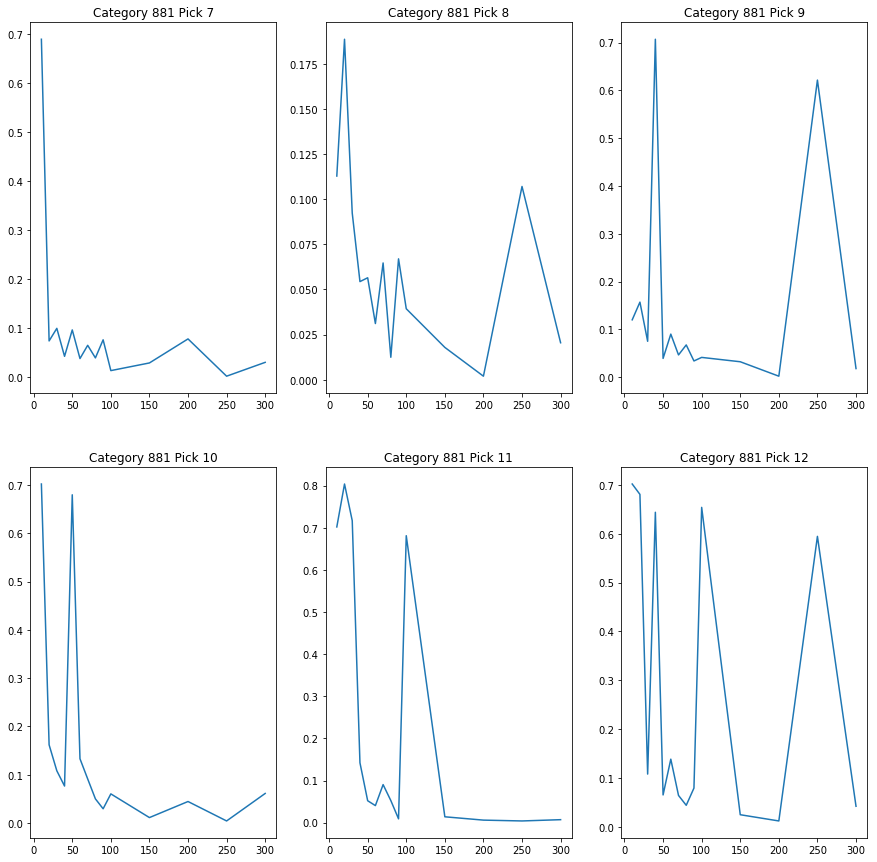

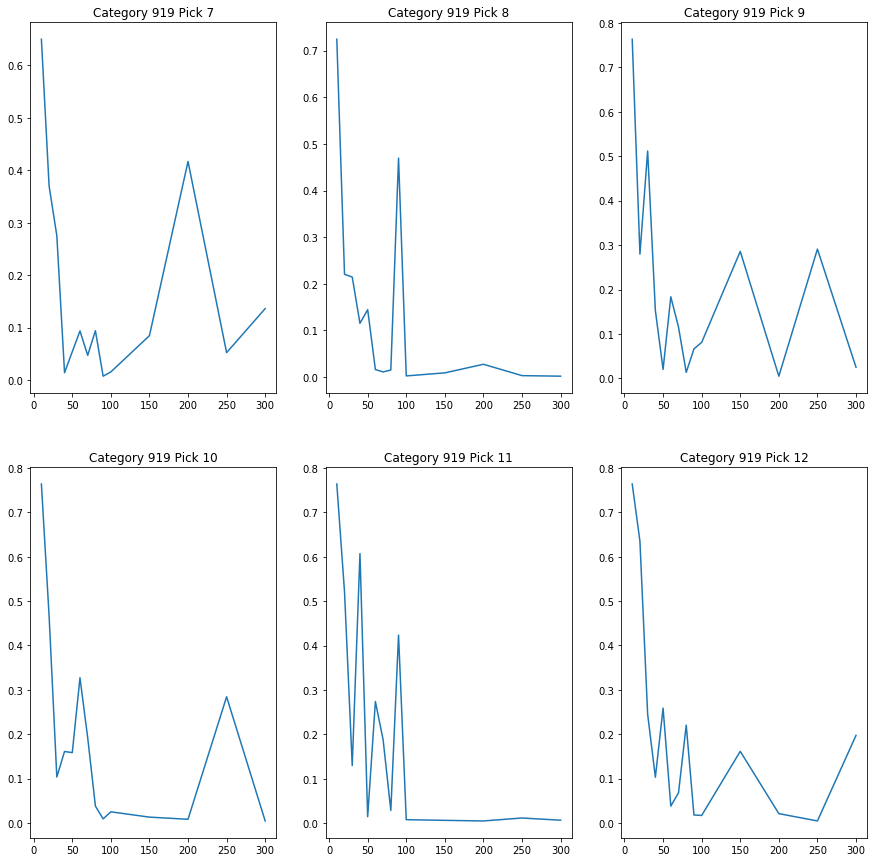

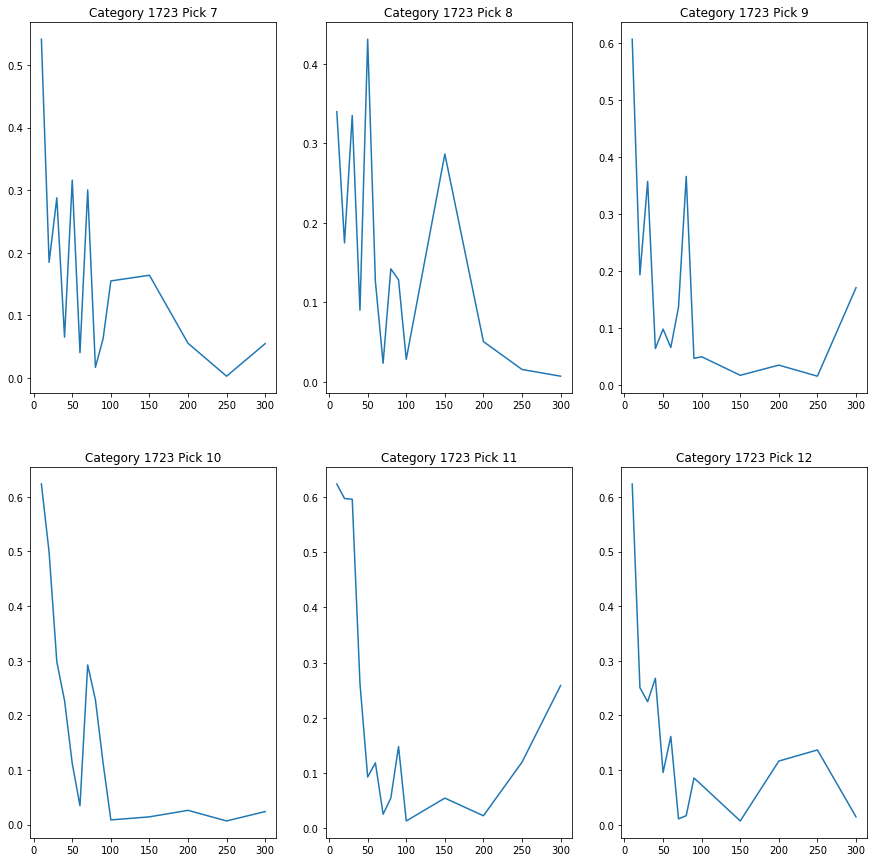

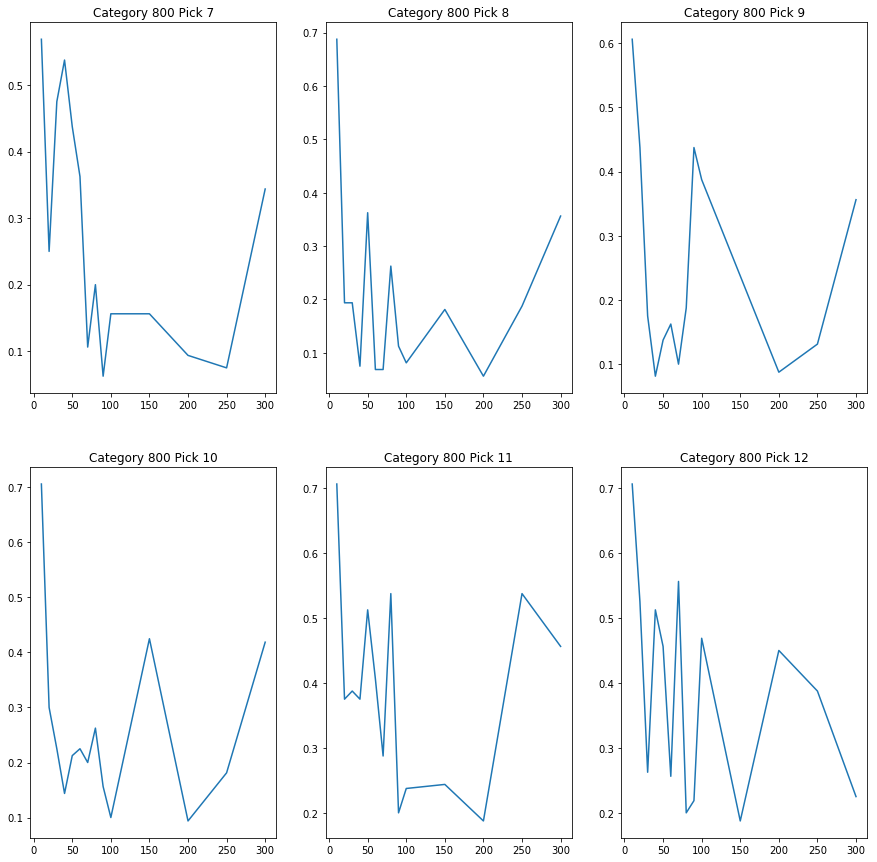

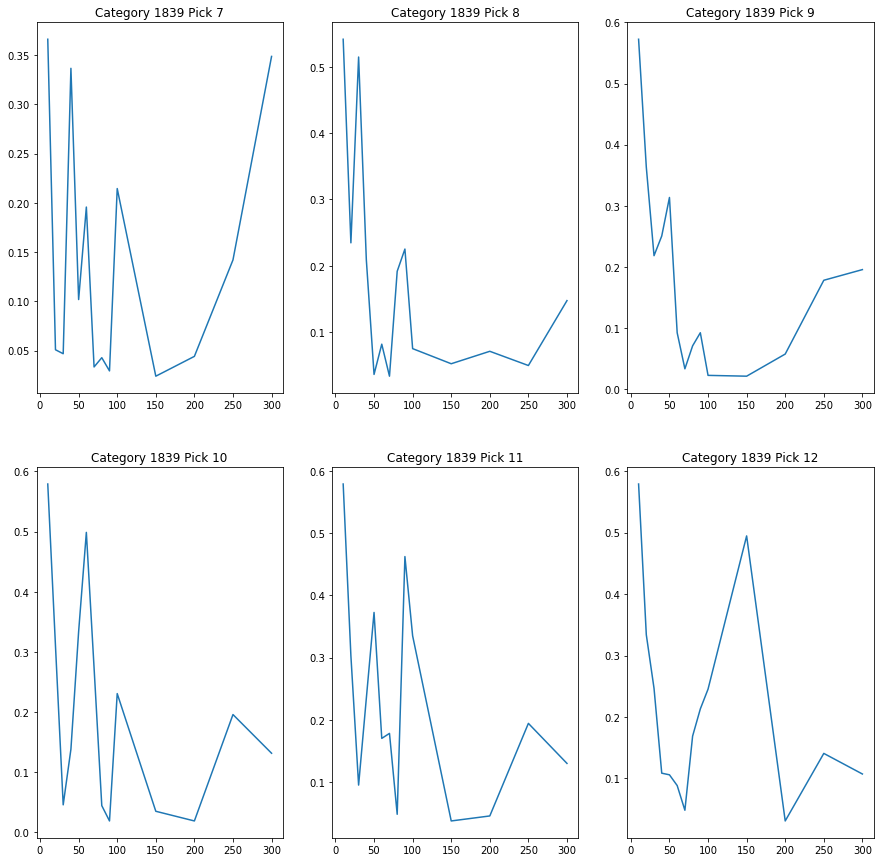

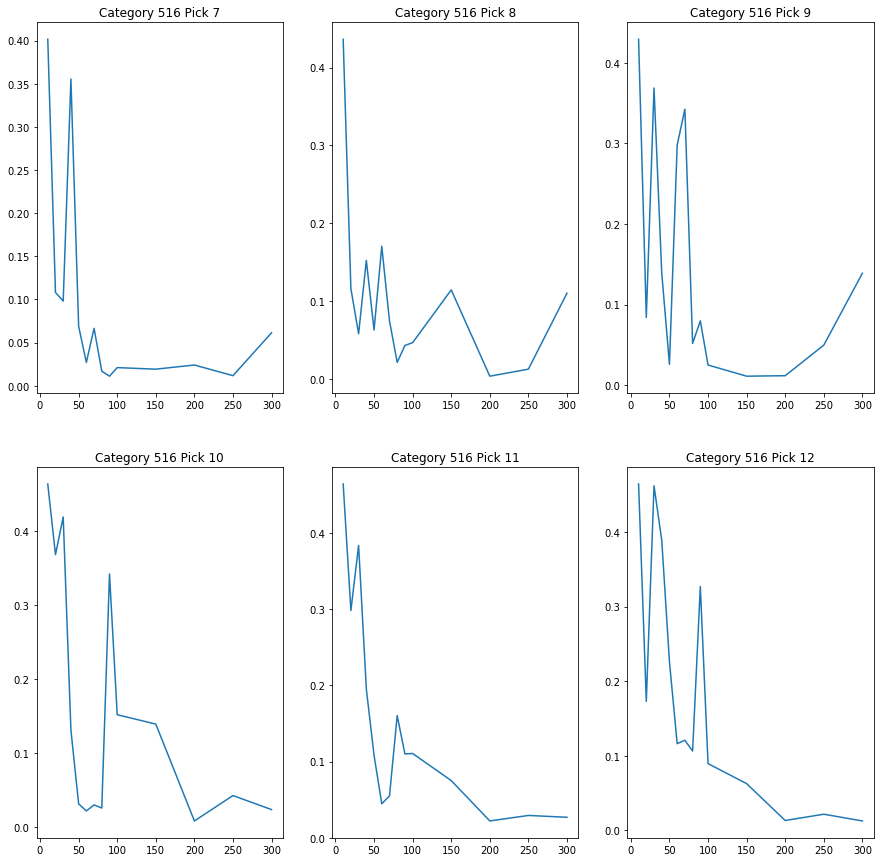

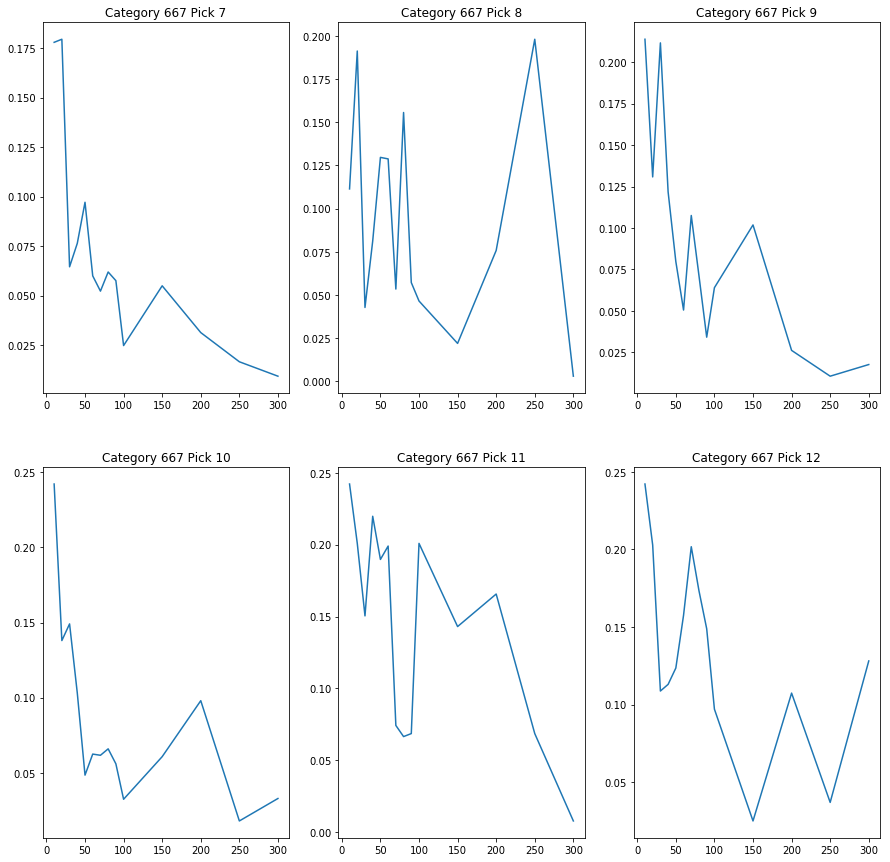

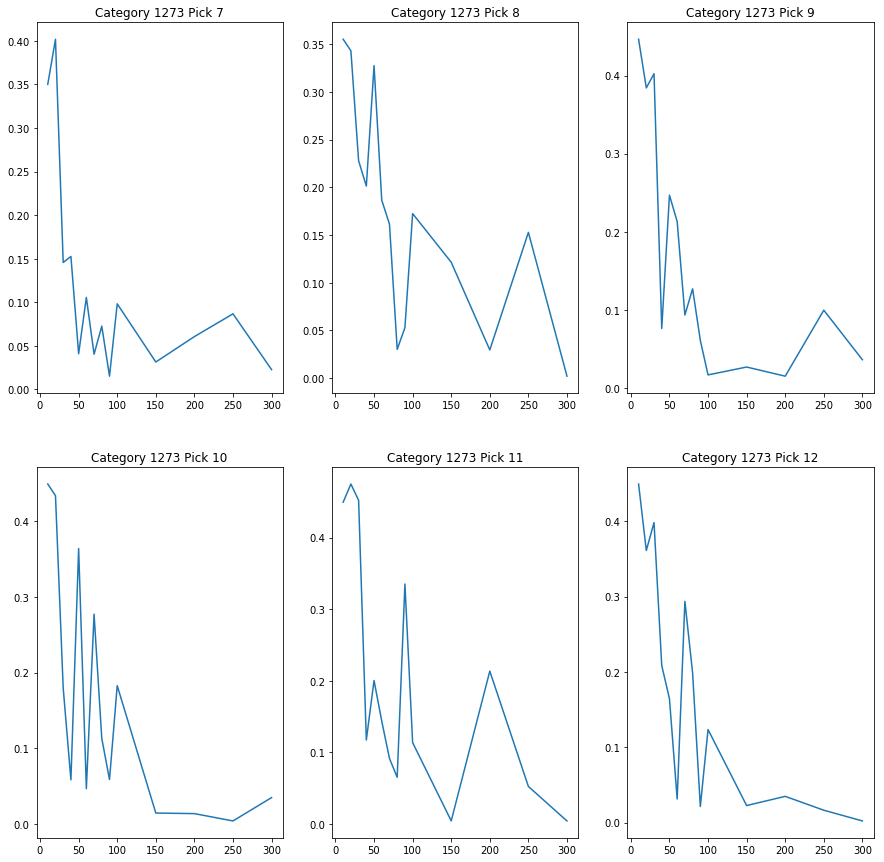

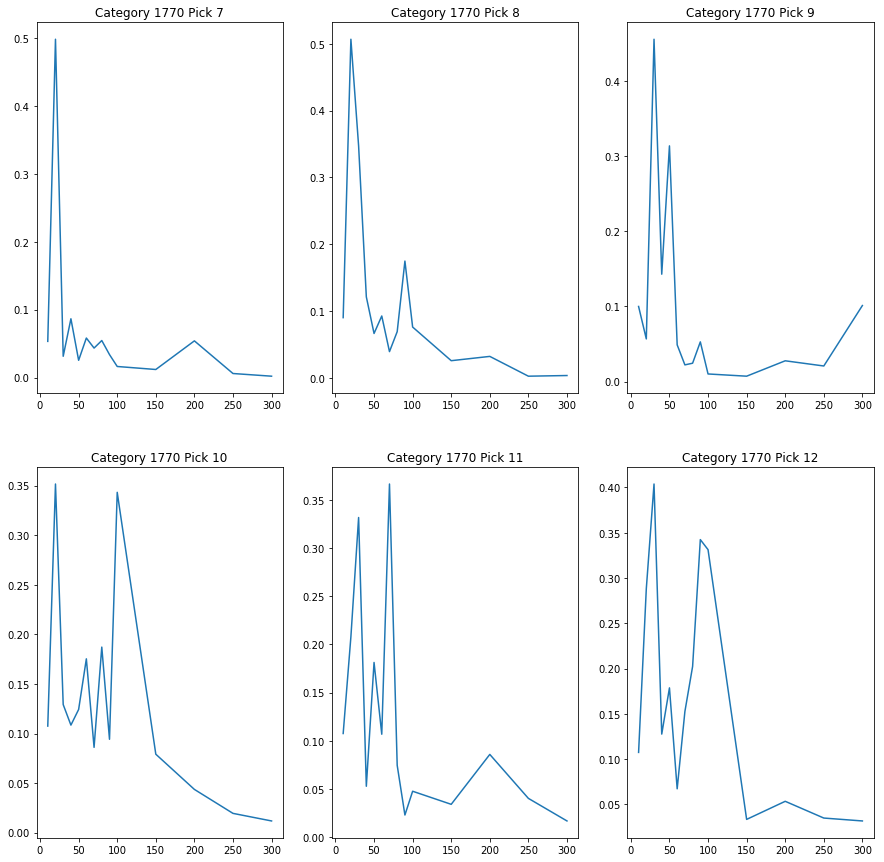

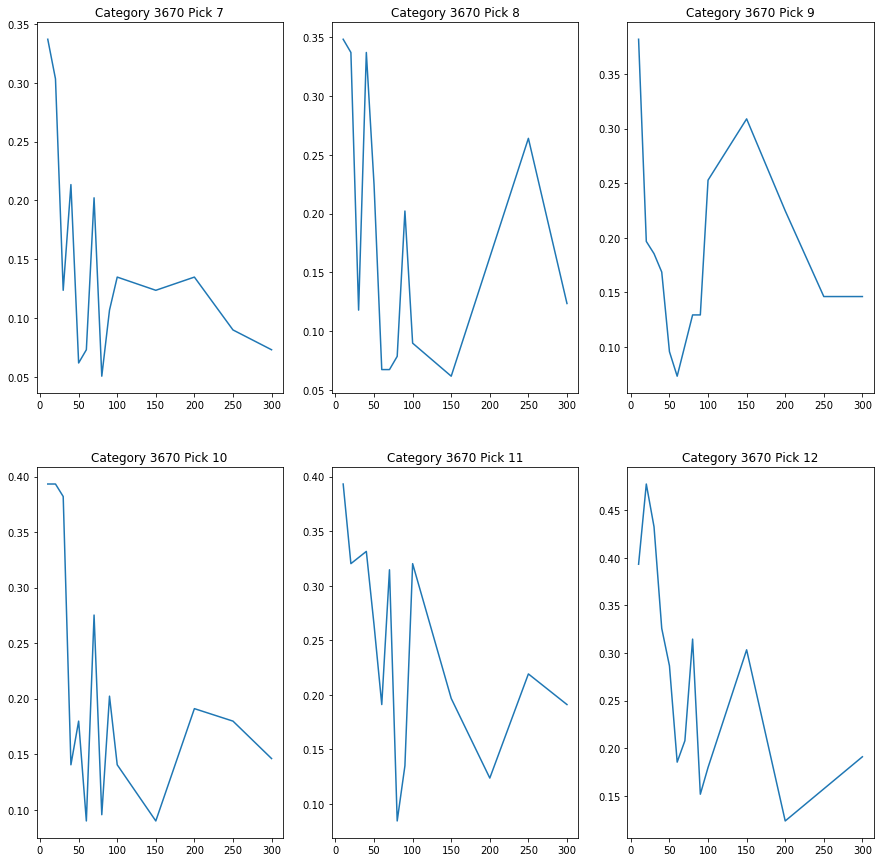

In [158]:
cat=np.random.permutation(new_cat_df['catnum'].unique())[:10]
arg_num_rec=[10,20,30,40,50,60,70,80,90,100,150,200,250,300]
pick = [7,8,9,10,11,12]
x=[]
y=[]
for m in cat:
    #print (m)
    indices = new_over_df[new_over_df['catnum']==m]['index'].unique()
    d=new_over_df[new_over_df['catnum']==str(m)]
    x=[]
    for k in pick:
        y=[]
        for i in arg_num_rec:
            #x.append(i)
            toprec = indices[np.argsort(matrix_co[indices])][-1 * i:][::-1]
            #print (len(toprec))
            #print (toprec)
            ind_random = np.random.permutation(toprec)
            pick_10 = ind_random[:k]
            #print (pick_10)
            cnt=0
            for j in range(len(d)):
                #print ('j'+str(j))
                #print (d)
                if d.iloc[j]['asin_index'] in pick_10:
                    #print ('in if')
                    cnt=cnt+1
            y.append(cnt/float(len(d)))
            #print ('Model accuracy with top '+ str(i) + ' and pick '+str(k)+': '+ str(float(cnt)/len(d)))
        #print ('y'+str(y))
        x.append(y)
    
    f, axarr = plt.subplots(2, 3,figsize=(15,15))
    k=0
    n=0
    for i in range(2):
        for j in range(3):
            try:
                axarr[i, j].plot(arg_num_rec,x[k])
                axarr[i, j].set_title('Category '+ str(m) +' Pick '+str(pick[n]))
                k=k+1
                n=n+1
                plt.sca(axes[i, j])
                plt.xticks(range(len(arg_num_rec)), arg_num_rec)
            except:
                pass
    plt.plot()

In [92]:
list_cat_names = []
with open('numcats.txt') as f:
    list_cat_names = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
list_cat_names = [x.strip() for x in list_cat_names]

In [96]:
list_cat={}
for i in list_cat_names:
    list_cat[int(i.split('\t')[0])]=i.split('\t')[1]

In [105]:
df_cat=pd.DataFrame.from_dict(list_cat,orient='index')

In [108]:
df_cat=df_cat.reset_index().rename(columns={'index':'catnum',0:'category'})

In [109]:
df_cat.head()

,catnum,category
0,0,N/A
1,1,.NET
2,2,16th Century
3,3,17th Century
4,4,1800s


In [163]:
df_cat[df_cat['catnum']==1273]

,catnum,category
1273,1273,Engineering & Transportation



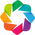

In [164]:
import pandas as pd
import holoviews as hv
import numpy as np
%matplotlib inline
hv.extension('bokeh', 'matplotlib', width="100")
%opts Curve [width=600 height=250 tools=['hover'] ] {+framewise} VLine (color="black")
%opts Bars  [width=800 height=400 tools=['hover'] group_index=1 legend_position='top_left' xrotation=90]

In [165]:
x=[10,20,30,40,50,100,150,200,250,300]
y=[0.012699215785479383,0.13659788225940514,0.2285352896534278,0.2842181345090528,0.34234397022153157,0.448137038777059,0.5517979111705396,0.6225651403996965,0.666408875718261,0.7060821798995338]

xlabel = "# of Customers"
ylabel = "Top N Books"
Title = "Customer Coverage"

In [166]:
rows = []

for i,j in zip(x,y):
    rows.append({xlabel:i,ylabel:j})

df = pd.DataFrame(rows, columns=[xlabel,ylabel])
topbooks_by_customers = df[[xlabel,ylabel]].groupby(xlabel).aggregate(np.sum)

In [167]:
topbooks_by_customers.reset_index(inplace=True)
topbooks_by_customers

,# of Customers,Top N Books
0,10,0.012699
1,20,0.136598
2,30,0.228535
3,40,0.284218
4,50,0.342344
5,100,0.448137
6,150,0.551798
7,200,0.622565
8,250,0.666409
9,300,0.706082


In [168]:
hv.Curve(topbooks_by_customers, xlabel, ylabel, group=Title)

TypeError: __init__() takes 2 positional arguments but 4 were given